In [1]:
import os
import sys

import geopandas as gpd
import pandas as pd
import numpy as np
from shapely import wkt

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Guadalajara hexagons

In [43]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'
city = 'Guadalajara'
type_area = 'urban'

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\' AND \"type\" = \'{type_area}\'"

hex_gdf = aup.gdf_from_query(query)
print(hex_gdf.shape)
hex_gdf.head(2)

(6540, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban


In [44]:
hex_diss = hex_gdf.copy()
hex_diss = hex_diss.to_crs("EPSG:32613")
hex_diss = hex_diss.buffer(5).reset_index().rename(columns={0: "geometry"})
hex_diss = hex_diss.set_geometry("geometry")
hex_diss = hex_diss.to_crs("EPSG:4326")
hex_diss = hex_diss.dissolve()

## Uso de suelo

In [4]:
us_gdf = gpd.read_file('../../../data/processed/viviendas_tlajo/hex_pct_uso_suelo.geojson')
us_gdf = us_gdf[['hex_id','pct_comercio','pct_equipamiento',
                'pct_habitacional','pct_industria','pct_otros',
                'pct_recreativo','pct_servicios','geometry']].copy()
print(us_gdf.shape)
us_gdf.head(2)

(106, 9)


,hex_id,pct_comercio,pct_equipamiento,pct_habitacional,pct_industria,pct_otros,pct_recreativo,pct_servicios,geometry
0,8949aa2ea37ffff,0.064688,0.109461,0.699288,0.010684,0.000000,0.007746,0.108133,"POLYGON ((668991.147 2270868.529, 669116.373 2..."
1,8949aa2eac7ffff,0.010642,0.068693,0.897237,0.007161,0.008467,0.000000,0.007800,"POLYGON ((670209.642 2269635.158, 670334.867 2..."


<Axes: >

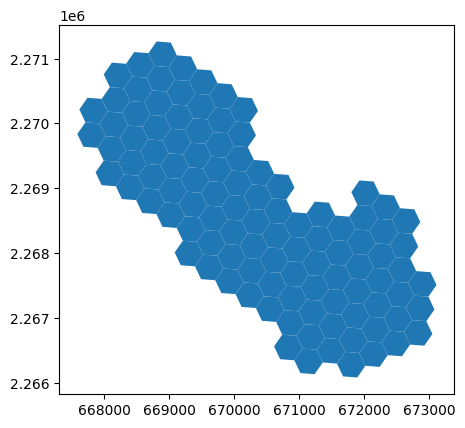

In [5]:
us_gdf.plot()

## Edificaciones

### Preprocessing

In [7]:
# ed_gdf = pd.read_csv('../../../data/raw/843_buildings.csv')
print(ed_gdf.shape)
ed_gdf.head(2)

(17536895, 6)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code
0,18.364032,-100.670645,60.4298,0.8018,"POLYGON((-100.670592415607 18.3640368370396, -...",75CX987H+JP97
1,20.446907,-103.526685,10.5973,0.7524,"POLYGON((-103.526667610397 20.4468944701841, -...",75GRCFWF+Q886


In [8]:
ed_gdf['geometry'] = ed_gdf['geometry'].apply(wkt.loads)
ed_gdf = gpd.GeoDataFrame(ed_gdf, crs='epsg:4326')

In [9]:
ed_clip = gpd.clip(ed_gdf, hex_diss)
print(ed_clip.shape)

(2418394, 6)


In [10]:
ed_clip = list(ed_clip.full_plus_code.unique())
bld_qro = ed_gdf.loc[(ed_gdf.full_plus_code).isin(ed_clip)]
print(bld_qro.shape)
bld_qro.head(2)

(2418394, 6)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code
3,20.639068,-103.276386,81.5991,0.7789,"POLYGON ((-103.27633 20.63905, -103.27635 20.6...",75GRJPQF+JCHP
22,20.535334,-103.420884,26.1395,0.8367,"POLYGON ((-103.42087 20.5353, -103.42086 20.53...",75GRGHPH+4JQ8


In [11]:
del ed_clip
del ed_gdf

### Read file

In [6]:
# bld_qro.to_file('../../../data/processed/viviendas_tlajo/buildings_amg.geojson')
bld_aoi = gpd.read_file('../../../data/processed/viviendas_tlajo/buildings_amg.geojson')

## Manzanas

In [7]:
poly_wkt = hex_diss.geometry.to_wkt()[0]

In [8]:
schema = 'marco'
table = 'mza_2020'

query = f"SELECT * FROM {schema}.{table} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"
mnz_gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(mnz_gdf.shape)
mnz_gdf.head(4)

(55357, 9)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
0,140390001496A022,14,039,0001,496A,022,Urbana,Típica,"POLYGON ((-103.32418 20.71651, -103.32482 20.7..."
1,140390001496A004,14,039,0001,496A,004,Urbana,Típica,"POLYGON ((-103.32694 20.71558, -103.32746 20.7..."
2,140390001496A003,14,039,0001,496A,003,Urbana,Típica,"POLYGON ((-103.32654 20.71519, -103.32687 20.7..."
3,140390001496A002,14,039,0001,496A,002,Urbana,Típica,"POLYGON ((-103.32552 20.7153, -103.32552 20.71..."


## Intersecciones

In [40]:
nodes = gpd.read_file('../../../data/processed/viviendas_tlajo/vertex_amg.geojson')
nodes = nodes[['geometry']]
print(nodes.shape)
nodes.head(2)

(110908, 1)


,geometry
0,POINT (653140.109 2296280.397)
1,POINT (653974.811 2296864.154)


## Vialidades

In [10]:
edges = gpd.read_file('../../../data/processed/viviendas_tlajo/vialidades_amg.geojson')
edges = edges.explode()
print(edges.shape)
edges.head(4)

(168957, 12)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,geometry
0,140390001,14,039,0001,03975,00007,Patria,Avenida,Dos sentidos,2,Urbana,"LINESTRING (667980.927 2290897.578, 668258.12 ..."
1,140390001,14,039,0001,03975,00008,Patria,Avenida,Dos sentidos,2,Urbana,"LINESTRING (668530.103 2291034.301, 668640.477..."
2,140390001,14,039,0001,03149,00001,Francisco Seles,Privada,Dos sentidos,2,Urbana,"LINESTRING (667164.932 2284845.291, 667183.517..."
3,140390001,14,039,0001,09070,00001,Malecón,Avenida,Dos sentidos,2,Urbana,"LINESTRING (680190.377 2289230.878, 680191.589..."


In [9]:
ss_gdf = gpd.read_file('../data/processed/VialidadesAMG_AngularChoice_INEGI19_UTM_v3.shp')
print(ss_gdf.shape)
ss_gdf.head(2)

DataSourceError: ../data/processed/VialidadesAMG_AngularChoice_INEGI19_UTM_v3.shp: No such file or directory

## Spatial anaylsis

### Land use

### Open space

In [11]:
mnz_diff = mnz_gdf.overlay(bld_aoi, how='difference')
print(mnz_diff.shape)
mnz_diff.head(2)

(55356, 9)


/home/edgaregurrola/.cache/pypoetry/virtualenvs/aup-qDsIK5d5-py3.11/lib/python3.11/site-packages/geopandas/geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 2594 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
0,140390001496A022,14,039,0001,496A,022,Urbana,Típica,"MULTIPOLYGON (((-103.32466 20.71658, -103.3246..."
1,140390001496A004,14,039,0001,496A,004,Urbana,Típica,"POLYGON ((-103.32694 20.71558, -103.32746 20.7..."


<Axes: >

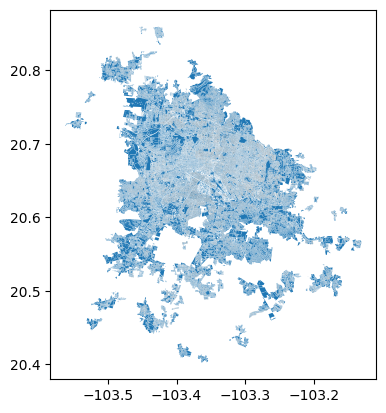

In [12]:
mnz_diff.plot()

1. Calcular área 2. Extraer centroides 3. Intersección por localización

In [13]:
mnz_diff_hex = mnz_diff.overlay(hex_gdf, how='intersection')
mnz_diff_hex = mnz_diff_hex.explode()

/home/edgaregurrola/.cache/pypoetry/virtualenvs/aup-qDsIK5d5-py3.11/lib/python3.11/site-packages/geopandas/geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 766 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


In [14]:
mnz_diff_hex['area_dif_ha'] = mnz_diff_hex.to_crs("EPSG:32613").area/10000
print(mnz_diff_hex.shape)
mnz_diff_hex.head(2)

(404610, 15)


,CVEGEO_1,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,hex_id_9,CVEGEO_2,NOMGEO,city,type,geometry,area_dif_ha
0,140390001496A022,14,039,0001,496A,022,Urbana,Típica,89498c94ed7ffff,14039,Guadalajara,Guadalajara,urban,"POLYGON ((-103.32472 20.7166, -103.32472 20.71...",0.037592
1,140390001496A022,14,039,0001,496A,022,Urbana,Típica,89498c94ed3ffff,14039,Guadalajara,Guadalajara,urban,"POLYGON ((-103.32466 20.71659, -103.32466 20.7...",0.038444


In [15]:
mnz_hex = mnz_gdf.overlay(hex_gdf, how='intersection')
mnz_hex = mnz_hex.explode()

In [16]:
mnz_hex['area_tot_ha'] = mnz_hex.to_crs("EPSG:32613").area/10000
print(mnz_hex.shape)
mnz_hex.head(2)

(96982, 15)


,CVEGEO_1,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,hex_id_9,CVEGEO_2,NOMGEO,city,type,geometry,area_tot_ha
0,140390001496A022,14,039,0001,496A,022,Urbana,Típica,89498c94ed7ffff,14039,Guadalajara,Guadalajara,urban,"POLYGON ((-103.32482 20.71651, -103.32482 20.7...",0.061405
1,140390001496A022,14,039,0001,496A,022,Urbana,Típica,89498c94ed3ffff,14039,Guadalajara,Guadalajara,urban,"POLYGON ((-103.32472 20.71651, -103.32452 20.7...",0.131788


In [17]:
mnz_hex = mnz_hex[['hex_id_9','area_tot_ha']].groupby('hex_id_9').sum()
mnz_diff_hex = mnz_diff_hex.groupby('hex_id_9').sum(numeric_only=True)
mnz_hex = mnz_hex.reset_index()
mnz_diff_hex = mnz_diff_hex.reset_index()
mnz_hex = mnz_hex.merge(mnz_diff_hex, on='hex_id_9')

In [18]:
mnz_hex['pct_openspace'] = mnz_hex['area_dif_ha'] / mnz_hex['area_tot_ha']
mnz_hex.head(4)

,hex_id_9,area_tot_ha,area_dif_ha,pct_openspace
0,89498c86483ffff,8.124647,5.570715,0.685656
1,89498c86487ffff,8.658752,5.876253,0.678649
2,89498c8648fffff,0.967100,0.651821,0.673995
3,89498c86493ffff,9.909715,5.664873,0.571648


In [19]:
mnz_hex = mnz_hex[['hex_id_9','pct_openspace']]

### Number of intersections

In [41]:
nodes = nodes.to_crs("EPSG:4326")

In [50]:
nodes_hex = nodes.overlay(hex_gdf, how='intersection')
print(nodes_hex.shape)
nodes_hex.head(4)

(105606, 6)


,hex_id_9,CVEGEO,NOMGEO,city,type,geometry
0,8949ab4ac3bffff,14120,Zapopan,Guadalajara,urban,POINT (-103.52895 20.75997)
1,8949ab4ac6fffff,14120,Zapopan,Guadalajara,urban,POINT (-103.52088 20.76518)
2,8949ab49227ffff,14120,Zapopan,Guadalajara,urban,POINT (-103.37523 20.80897)
3,8949ab49627ffff,14120,Zapopan,Guadalajara,urban,POINT (-103.37595 20.78721)


In [53]:
nodes_hex = nodes_hex.groupby('hex_id_9').count().reset_index()
nodes_hex = nodes_hex[['hex_id_9','CVEGEO']].rename(columns={'CVEGEO':'number_intersections'})
nodes_hex.head(4)

,hex_id_9,number_intersections
0,89498c86483ffff,29
1,89498c86487ffff,17
2,89498c8648fffff,2
3,89498c86493ffff,27


array([[<Axes: title={'center': 'number_intersections'}>]], dtype=object)

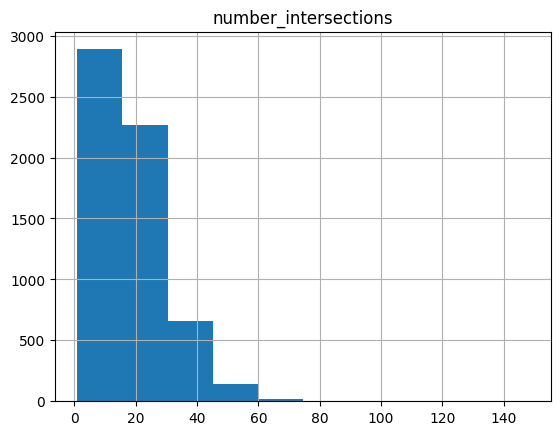

In [54]:
nodes_hex.hist()

### Building size average

In [26]:
hex_bld = hex_gdf.overlay(bld_aoi, how='intersection')
hex_bld['area_in_meters'] = hex_bld.to_crs("EPSG:6372").area
print(hex_bld.shape)
hex_bld.head(2)

(2551510, 11)


,hex_id_9,CVEGEO,NOMGEO,city,type,latitude,longitude,area_in_meters,confidence,full_plus_code,geometry
0,89498c96e0bffff,14039,Guadalajara,Guadalajara,urban,20.669040,-103.354335,16.302328,0.7456,75GRMJ9W+J77M,"POLYGON ((-103.35436 20.66902, -103.35435 20.6..."
1,89498c96e0bffff,14039,Guadalajara,Guadalajara,urban,20.668044,-103.354155,42.584010,0.7448,75GRMJ9W+689J,"POLYGON ((-103.35412 20.66801, -103.3542 20.66..."


In [27]:
hex_bld = hex_bld.groupby('hex_id_9').mean(numeric_only=True)
hex_bld = hex_bld.reset_index()
hex_bld = hex_bld[['hex_id_9','area_in_meters']].copy()
print(hex_bld.shape)
hex_bld.head(2)

(6458, 2)


,hex_id_9,area_in_meters
0,89498c86483ffff,41.937266
1,89498c86487ffff,49.638048


### Street area

In [28]:
edges = edges.to_crs("EPSG:4326")
edges_hex = edges.overlay(hex_gdf, how='intersection')
edges_hex['len_km'] = edges_hex.to_crs("EPSG:32613").length / 1000
edges_hex = edges_hex.groupby('hex_id_9').sum(numeric_only =True)
edges_hex = edges_hex.reset_index()
edges_hex = edges_hex[['hex_id_9','len_km']]
print(edges_hex.shape)
edges_hex.head(2)

(6219, 2)


,hex_id_9,len_km
0,89498c86483ffff,2.389166
1,89498c86487ffff,2.571883


In [29]:
tmp_hex = hex_gdf.overlay(mnz_gdf, how='difference')
tmp_hex['area_ha'] = tmp_hex.to_crs("EPSG:32613").area / 10000
tmp_hex = tmp_hex[['hex_id_9','area_ha']]
print(tmp_hex.shape)
tmp_hex.head(2)

(6502, 2)


,hex_id_9,area_ha
0,89498c96e0bffff,3.469683
1,89498c960a3ffff,3.509815


In [30]:
edges_hex = edges_hex.merge(tmp_hex, on='hex_id_9')
edges_hex['street_dens'] = edges_hex['len_km'] / edges_hex['area_ha']
edges_hex = edges_hex[['hex_id_9','street_dens']]
edges_hex.head(4)

,hex_id_9,street_dens
0,89498c86483ffff,0.549096
1,89498c86487ffff,0.673764
2,89498c8648fffff,0.030616
3,89498c86493ffff,1.170203


### Street syntax

In [31]:
ss_gdf = ss_gdf.to_crs("EPSG:4326")
ss_gdf = ss_gdf[['NI_sl500','geometry']]
ss_hex = ss_gdf.overlay(hex_gdf, how='intersection')
print(ss_hex.shape)
ss_hex.head(2)

NameError: name 'ss_gdf' is not defined

In [ ]:
ss_hex['length_km'] = ss_hex.to_crs("EPSG:32613").length / 1000
ss_tot = ss_hex.groupby('hex_id_9').sum()
ss_tot = ss_tot.reset_index()
ss_tot = ss_tot[['hex_id_9','length_km']]
ss_tot = ss_tot.rename(columns={'length_km':'length_tot_km'})
ss_tot.head(4)

In [35]:
ss_hex = ss_hex.merge(ss_tot, on='hex_id_9')
ss_hex['pct_ss'] = ss_hex['length_km'] / ss_hex['length_tot_km']
ss_hex['wgt_ss'] = ss_hex['pct_ss'] * ss_hex['NI_sl500']
ss_hex = ss_hex.groupby('hex_id_9').sum()
ss_hex = ss_hex.reset_index()
ss_hex = ss_hex[['hex_id_9','wgt_ss']]
ss_hex.head(2)

/tmp/ipykernel_74187/660076386.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ss_hex = ss_hex.groupby('hex_id_9').sum()


,hex_id_9,wgt_ss
0,89498c94003ffff,1.147223
1,89498c94007ffff,1.049694


## Hexagon data

In [55]:
hex_gdf = hex_gdf.merge(us_gdf.drop(columns=['geometry']), left_on='hex_id_9',
                        right_on='hex_id',
                       how='left')
hex_gdf = hex_gdf.merge(mnz_hex, on='hex_id_9',
                       how='left')
hex_gdf = hex_gdf.merge(edges_hex, on='hex_id_9',
                       how='left')
# hex_gdf = hex_gdf.merge(ss_hex, on='hex_id_9')
hex_gdf = hex_gdf.merge(nodes_hex, on='hex_id_9',
                       how='left')
hex_gdf = hex_gdf.merge(hex_bld, on='hex_id_9',
                       how='left')
hex_gdf = hex_gdf.fillna(0)
print(hex_gdf.shape)
hex_gdf.head(4)

(6540, 18)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,hex_id,pct_comercio,pct_equipamiento,pct_habitacional,pct_industria,pct_otros,pct_recreativo,pct_servicios,pct_openspace,street_dens,number_intersections,area_in_meters
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.401130,0.791346,18.0,71.593758
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.743705,0.338610,4.0,316.402206
2,89498c97333ffff,"POLYGON ((-103.27379 20.66284, -103.27257 20.6...",14039,Guadalajara,Guadalajara,urban,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.368786,1.049153,31.0,70.335294
3,89498c96063ffff,"POLYGON ((-103.33352 20.63689, -103.3323 20.63...",14039,Guadalajara,Guadalajara,urban,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.743073,0.367507,3.0,248.457964


<Axes: >

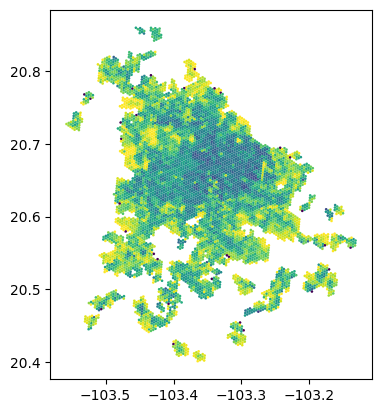

In [56]:
hex_gdf.plot('pct_openspace')

<Axes: >

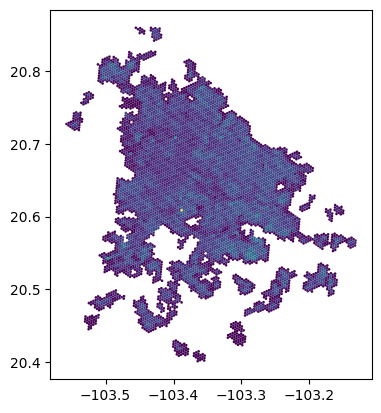

In [57]:
hex_gdf.plot('street_dens')

<Axes: >

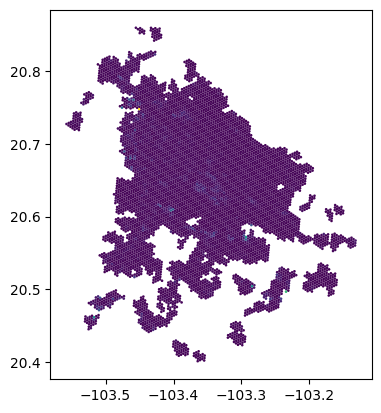

In [58]:
hex_gdf.plot('area_in_meters')

## Filter data

In [59]:
aoi_gdf = gpd.read_file('../../../data/processed/viviendas_tlajo/AOI_Viviendas_Tlajo.geojson')

In [60]:
if hex_gdf.crs!=aoi_gdf.crs:
    hex_gdf = hex_gdf.to_crs(aoi_gdf.crs)
    print(hex_gdf.crs)

EPSG:32613


In [61]:
hex_clip_id = hex_gdf.clip(aoi_gdf).hex_id_9.unique()
hex_us_aoi = hex_gdf.loc[hex_gdf.hex_id_9.isin(hex_clip_id)].copy()
print(hex_us_aoi.shape)
hex_us_aoi.head(2)

(133, 18)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,hex_id,pct_comercio,pct_equipamiento,pct_habitacional,pct_industria,pct_otros,pct_recreativo,pct_servicios,pct_openspace,street_dens,number_intersections,area_in_meters
1620,8949aa2ea37ffff,"POLYGON ((668991.147 2270868.529, 669116.373 2...",14097,Tlajomulco de Zúñiga,Guadalajara,urban,8949aa2ea37ffff,0.064688,0.109461,0.699288,0.010684,0.000000,0.007746,0.108133,0.661597,0.929265,37.0,47.320755
1630,8949aa2eac7ffff,"POLYGON ((670209.642 2269635.158, 670334.867 2...",14097,Tlajomulco de Zúñiga,Guadalajara,urban,8949aa2eac7ffff,0.010642,0.068693,0.897237,0.007161,0.008467,0.000000,0.007800,0.587723,0.190374,17.0,82.202880


## Save data

In [62]:
hex_us_aoi.to_file('../../../data/processed/viviendas_tlajo/hex_urban_structure.geojson')